In [1]:
import torch
from OverwriteGrad.nn import Linear, ReLU, Softmax, LayerNorm, TransformerDecoder, TransformerDecoderLayer
import OverwriteGrad.nn.functional as F
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = torch.tensor(x_train).float().reshape(60_000, 784).cuda(), torch.tensor(y_train).long().cuda()
x_test, y_test = torch.tensor(x_test).float().reshape(x_test.shape[0], 784).cuda(), torch.tensor(y_test).long().cuda()

print(f"x_train: {x_train.shape}, y_train: {y_train.shape}, x_test: {x_test.shape}, y_test: {y_test.shape} ")

x_train: torch.Size([60000, 784]), y_train: torch.Size([60000]), x_test: torch.Size([10000, 784]), y_test: torch.Size([10000]) 


In [36]:
def plotModelSVD(model: torch.nn.Module):
    names = []
    singluar_values = [] 
    for name, param in model.named_parameters():
        p = param
        if len(p.shape) == 1:
            p = p.unsqueeze(0) # make svd-able
        _, S, _ = torch.linalg.svd(p)
        names.append(name)
        singluar_values.append(S)
    fig, ax = plt.subplots()
    # plot means
    svd_means = [torch.mean(s) for s in singluar_values]
    svd_maxes = [torch.max(s) for s in singluar_values]
    plt.xticks(rotation=90)
    ax.bar(names, svd_maxes)
    ax.bar(names, svd_means)


Epoch: 0, acc: 0.0833333358168602, loss: 2.3306474685668945, val: 0.0876999944448471
Epoch: 50, acc: 0.8474666476249695, loss: 1.615727186203003, val: 0.8454999923706055
Epoch: 100, acc: 0.8717833161354065, loss: 1.590449571609497, val: 0.8650999665260315
Epoch: 150, acc: 0.8816333413124084, loss: 1.5794410705566406, val: 0.8696999549865723
Epoch: 200, acc: 0.8860999941825867, loss: 1.5737347602844238, val: 0.8741999864578247
Epoch: 250, acc: 0.9836500287055969, loss: 1.4789193868637085, val: 0.965399980545044
Epoch: 300, acc: 0.9873499870300293, loss: 1.4745445251464844, val: 0.9686999917030334
Epoch: 350, acc: 0.9886333346366882, loss: 1.4729719161987305, val: 0.9696999788284302
Epoch: 400, acc: 0.9895666837692261, loss: 1.4718984365463257, val: 0.9693999886512756
Epoch: 450, acc: 0.9900500178337097, loss: 1.4713151454925537, val: 0.9692999720573425
Epoch: 500, acc: 0.9904666543006897, loss: 1.470853567123413, val: 0.9693999886512756
Epoch: 550, acc: 0.9907333254814148, loss: 1.47049

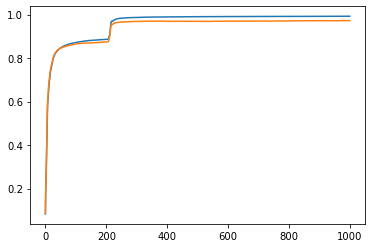

In [5]:
model =  torch.nn.Sequential(
    Linear(784, 128),
    ReLU(),
    Linear(128, 256),
    ReLU(),
    Linear(256, 128),
    ReLU(),
    Linear(128, 10),
    Softmax()
).to("cuda")
opt = torch.optim.Adam(model.parameters(), lr=3e-4)
model.zero_grad()
training_acc = []
validation_acc = []
for i in range(1000):
    opt.zero_grad()
    pred = model(x_train)
    loss = torch.nn.functional.cross_entropy(pred, y_train)
    acc = (torch.argmax(pred, -1)==y_train).float().mean()
    training_acc.append(acc)
    validation_acc.append((torch.argmax(model(x_test), -1)==y_test).float().mean())
    if i % 50 == 0:
        print(f"Epoch: {i}, acc: {acc}, loss: {loss.item()}, val: {validation_acc[-1]}")
    loss.backward()
    opt.step()
fig, ax = plt.subplots()
ax.plot(list(range(1000)), training_acc)
ax.plot(list(range(1000)), validation_acc)
plt.show()



Epoch: 0, acc: 0.05701666697859764, loss: 2.38515567779541, val: 0.057999998331069946
Epoch: 50, acc: 0.6774333119392395, loss: 1.78193199634552, val: 0.6796999573707581
Epoch: 100, acc: 0.692466676235199, loss: 1.7662267684936523, val: 0.6908000111579895
Epoch: 150, acc: 0.699150025844574, loss: 1.7582567930221558, val: 0.694599986076355
Epoch: 200, acc: 0.7031166553497314, loss: 1.7531541585922241, val: 0.6958000063896179
Epoch: 250, acc: 0.7889000177383423, loss: 1.6697202920913696, val: 0.7788999676704407
Epoch: 300, acc: 0.7933499813079834, loss: 1.6635828018188477, val: 0.7802000045776367
Epoch: 350, acc: 0.8825666904449463, loss: 1.5781190395355225, val: 0.8712999820709229
Epoch: 400, acc: 0.8894500136375427, loss: 1.569506049156189, val: 0.8757999539375305
Epoch: 450, acc: 0.985966682434082, loss: 1.476250171661377, val: 0.967199981212616
Epoch: 500, acc: 0.9884499907493591, loss: 1.4731712341308594, val: 0.9684999585151672
Epoch: 550, acc: 0.9894166588783264, loss: 1.472080469

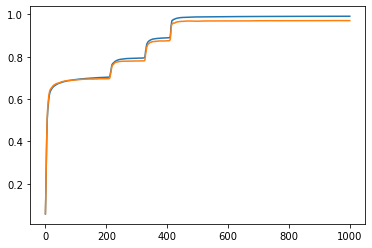

In [4]:
modelTorch =  torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 10),
    torch.nn.Softmax()
).to("cuda")
opt = torch.optim.Adam(modelTorch.parameters(), lr=3e-4)
modelTorch.zero_grad()
training_acc = []
validation_acc = []
for i in range(1000):
    opt.zero_grad()
    pred = modelTorch(x_train)
    loss = torch.nn.functional.cross_entropy(pred, y_train)
    acc = (torch.argmax(pred, -1)==y_train).float().mean()
    training_acc.append(acc)
    validation_acc.append((torch.argmax(modelTorch(x_test), -1)==y_test).float().mean())
    if i % 50 == 0:
        print(f"Epoch: {i}, acc: {acc}, loss: {loss.item()}, val: {validation_acc[-1]}")
    loss.backward()
    opt.step()
fig, ax = plt.subplots()
ax.plot(list(range(1000)), training_acc)
ax.plot(list(range(1000)), validation_acc)
plt.show()


In [10]:
def gen_data(n_training_data: int, p: int, device: str = "cuda"):
    # generate all possible equations for mod p
    all_data = []
    for i in range(p):
        for j in range(p):
           all_data.append([i,j,(i+j)%p])
    
    all_data = np.array(all_data)
    indices = np.random.permutation(all_data.shape[0])
    train_indices = indices[:n_training_data]
    valid_indices = indices[n_training_data:]
    
    input_seq: np.ndarray = all_data.copy()
    output_seq = input_seq.copy()
    input_seq[:, -1] = 0 # don't include answers

    train_x = (torch.tensor(input_seq[train_indices]).long().to(device))
    train_y = (torch.tensor(output_seq[train_indices]).long().to(device))
    valid_x = (torch.tensor(input_seq[valid_indices]).long().to(device))
    valid_y = (torch.tensor(output_seq[valid_indices]).long().to(device))

    return (train_x, train_y), (valid_x, valid_y)
def onehot(x: torch.Tensor, n_classes: int) -> torch.Tensor:
    return (torch.nn.functional.one_hot(x, n_classes))

(train_x, train_y), (valid_x, valid_y) = gen_data(1200, 97, device="cuda")
train_x = onehot(train_x, 128).float()
valid_x = onehot(valid_x, 128).float()

In [40]:
class Transformer(torch.nn.Module):
    def __init__(self, seq_length: int, num_embeddings: int, d_model: int, dim_feedforward: int = 2048):
        super().__init__()
        self.d_model = d_model
        self.num_embeddings = num_embeddings

        self.decoder_layer = TransformerDecoderLayer(self.d_model, nhead=4, dim_feedforward=dim_feedforward,
                                        dropout=0.1, batch_first=True, norm_first=True)
        decoder_norm = LayerNorm(self.d_model)

        self.decoder = TransformerDecoder(
            self.decoder_layer, num_layers=2, norm=decoder_norm)

        self.linear = Linear(
            self.d_model, self.num_embeddings, bias=False)
        self.mask = torch.nn.Parameter(
            (torch.ones([seq_length, seq_length]).tril()))
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.decoder.forward(x, torch.zeros_like(x), self.mask) 
        #x = self.decoder_layer.forward(x, torch.zeros_like(x))  # todo: less dumb
        return self.linear(x)

    def acc(self, prediction: torch.Tensor, labels: torch.Tensor):
        return (torch.argmax(prediction, dim=-2) == labels).float().mean()


model = Transformer(train_x.size(-2), 97, 128).to("cuda")
opt = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-2, betas=[0.9, 0.98]) 
for i in range(12000):
    opt.zero_grad()
    output = model.forward(train_x)

    pred = output.transpose(-2, -1) # todo possibel fix
    pred = pred[..., -1:]
    label = train_y[:, -1:]
    loss = torch.nn.functional.cross_entropy(pred, label)
    acc = model.acc(pred, label)
    with torch.no_grad():
        valp = model.forward(valid_x).transpose(-2,-1)[..., -1:]
        val_acc = model.acc(valp, valid_y[:, -1:])
    if i % 50 == 0:
        print(f"Epoch {i}: loss {loss.item():e}, training_accuracy {acc}, validation_accuracy: {val_acc}")
    loss.backward()
    opt.step()

Epoch 0: loss 4.751855e+00, training_accuracy 0.007500000298023224, validation_accuracy: 0.009867219254374504
Epoch 50: loss 2.991054e+00, training_accuracy 0.40833333134651184, validation_accuracy: 0.03569253161549568
Epoch 100: loss 1.429534e+00, training_accuracy 0.8941667079925537, validation_accuracy: 0.10695578157901764
Epoch 150: loss 5.523330e-01, training_accuracy 0.9825000166893005, validation_accuracy: 0.12413205206394196
Epoch 200: loss 2.663054e-01, training_accuracy 0.9950000047683716, validation_accuracy: 0.12693385779857635
Epoch 250: loss 1.869895e-01, training_accuracy 0.996666669845581, validation_accuracy: 0.12656840682029724
Epoch 300: loss 1.620454e-01, training_accuracy 0.9991666674613953, validation_accuracy: 0.12620294094085693
Epoch 350: loss 1.448212e-01, training_accuracy 0.9975000023841858, validation_accuracy: 0.12632475793361664
Epoch 400: loss 1.454095e-01, training_accuracy 0.9983333349227905, validation_accuracy: 0.12632475793361664
Epoch 450: loss 1.4

KeyboardInterrupt: 

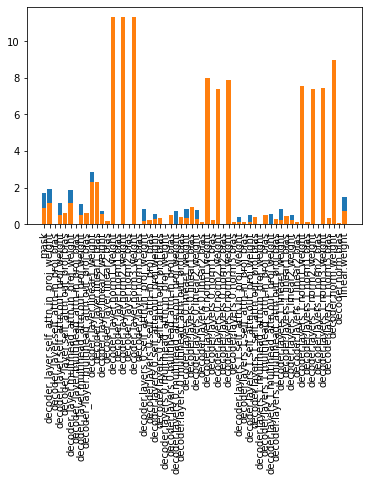

In [41]:
plotModelSVD(model)

In [44]:
class Transformer(torch.nn.Module):
    def __init__(self, seq_length: int, num_embeddings: int, d_model: int, dim_feedforward: int = 2048):
        super().__init__()
        self.d_model = d_model
        self.num_embeddings = num_embeddings

        self.decoder_layer = torch.nn.TransformerDecoderLayer(self.d_model, nhead=4, dim_feedforward=dim_feedforward,
                                        dropout=0.1, batch_first=True, norm_first=True)
        decoder_norm = torch.nn.LayerNorm(self.d_model)

        self.decoder = torch.nn.TransformerDecoder(
            self.decoder_layer, num_layers=2, norm=decoder_norm)
        self.linear = torch.nn.Linear(
            self.d_model, self.num_embeddings, bias=False)
        self.mask = torch.nn.Parameter(
            (torch.ones([seq_length, seq_length]).tril()))

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        x = self.decoder.forward(x, torch.zeros_like(x), self.mask)  # todo: less dumb
        #x = self.decoder_layer.forward(x, torch.zeros_like(x))
        return self.linear(x)

    def acc(self, prediction: torch.Tensor, labels: torch.Tensor):
        return (torch.argmax(prediction, dim=-2) == labels).float().mean()


model = Transformer(train_x.size(-2), 97, 128).to("cuda")
opt = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-2, betas=[0.9, 0.98]) 
for i in range(12000):
    opt.zero_grad()
    output = model.forward(train_x)

    pred = output.transpose(-2, -1) # todo possibel fix
    pred = pred[..., -1:]
    label = train_y[:, -1:]
    loss = torch.nn.functional.cross_entropy(pred, label)
    acc = model.acc(pred, label)
    with torch.no_grad():
        valp = model.forward(valid_x).transpose(-2,-1)[..., -1:]
        val_acc = model.acc(valp, valid_y[:, -1:])
    if i % 50 == 0:
        print(f"Epoch {i}: loss {loss.item():e}, training_accuracy {acc}, validation_accuracy: {val_acc}")
    loss.backward()
    opt.step()

Epoch 0: loss 4.695361e+00, training_accuracy 0.013333333656191826, validation_accuracy: 0.009258131496608257
Epoch 50: loss 7.411098e-01, training_accuracy 0.9041666984558105, validation_accuracy: 0.11097575724124908
Epoch 100: loss 6.079684e-01, training_accuracy 0.893333375453949, validation_accuracy: 0.1140211969614029
Epoch 150: loss 2.528488e-01, training_accuracy 0.987500011920929, validation_accuracy: 0.12388841807842255
Epoch 200: loss 2.408696e-01, training_accuracy 0.9766666889190674, validation_accuracy: 0.12364477664232254


KeyboardInterrupt: 

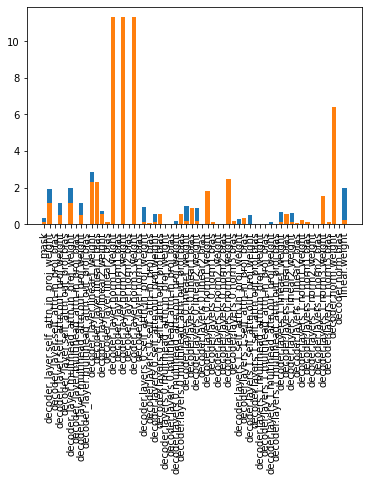

In [39]:
plotModelSVD(model)


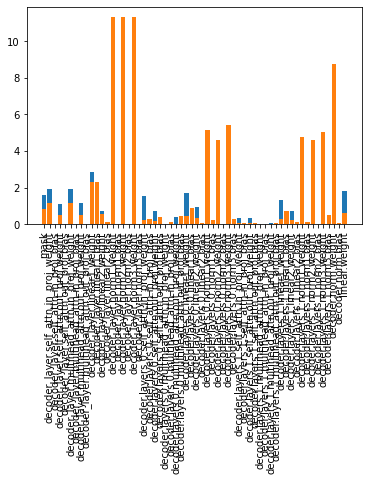

In [45]:
plotModelSVD(model)

In [30]:
modelTorch =  torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 10),
    torch.nn.Softmax()
).to("cuda")
opt = torch.optim.Adam(modelTorch.parameters(), lr=1e-3)
modelTorch.zero_grad()
for i in range(100):
    
    for batch in range(1875):
        opt.zero_grad()
        pred = modelTorch(xnormal[batch*32:(batch+1)*32])
        loss = torch.nn.functional.cross_entropy(pred, y_train[batch*32:(batch+1)*32])
        loss.backward()
        opt.step()
    acc = (torch.argmax(modelTorch(xnormal), -1)==y_train).float().mean()
    print(f"Epoch: {i}, acc: {acc}")



/home/eli/anaconda3/envs/cmsc320/lib/python3.8/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 0, acc: 0.9321333169937134
Epoch: 1, acc: 0.9470500349998474
Epoch: 2, acc: 0.9536333680152893
Epoch: 3, acc: 0.962933361530304


KeyboardInterrupt: 

In [6]:
model(x_train)

/home/eli/anaconda3/envs/cmsc320/lib/python3.8/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([[7.4316e-03, 2.3545e-05, 4.8926e-02,  ..., 2.2784e-02, 4.7637e-01,
         1.1021e-01],
        [5.5724e-04, 9.7987e-02, 1.1583e-02,  ..., 7.5222e-03, 7.2502e-01,
         3.4519e-02],
        [7.5035e-02, 5.3533e-05, 1.8682e-01,  ..., 1.1997e-01, 9.9376e-02,
         1.0947e-02],
        ...,
        [1.8621e-02, 8.3624e-04, 2.0853e-01,  ..., 6.2889e-02, 1.8880e-01,
         3.6056e-01],
        [6.3993e-04, 6.6225e-03, 1.5063e-01,  ..., 6.9055e-02, 3.7833e-02,
         4.4126e-02],
        [6.2566e-03, 1.1765e-02, 2.9381e-02,  ..., 3.3292e-02, 7.5407e-02,
         4.4836e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [31]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu, input_shape= x_train.shape[1:]))
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax)) 
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer='adam',  # Good default optimizer to start with
              loss='sparse_categorical_crossentropy',  # how will we calculate our "error." Neural network aims to minimize loss.
              metrics=['accuracy'])


In [32]:
model.fit(x_train.clone().cpu().numpy(), y_train.clone().cpu().numpy(), epochs=3)

Epoch 1/3
1875/1875 [==============================] - 7s 3ms/step - loss: 4.9657 - accuracy: 0.8185
Epoch 2/3
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3804 - accuracy: 0.9306
Epoch 3/3
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2052 - accuracy: 0.9479


In [37]:
np.mean(tf.argmax(model.predict(x_train.clone().cpu().numpy(),), -1) ==  y_train.clone().cpu().numpy())

0.9605166666666667

In [21]:
modelTorch =  torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 10),
    torch.nn.Softmax()
).to("cuda")
opt = torch.optim.Adam(modelTorch.parameters(), lr=1e-3)
modelTorch.zero_grad()
for i in range(100):
    opt.zero_grad()
    pred = modelTorch(x_train)
    loss = torch.nn.functional.cross_entropy(pred, y_train)
    loss.backward()
    opt.step()
    acc = (torch.argmax(modelTorch(x_train), -1)==y_train).float().mean()
    print(f"Epoch: {i}, acc: {acc}")


Epoch: 0, acc: 0.19715000689029694
Epoch: 1, acc: 0.31878334283828735
Epoch: 2, acc: 0.35705000162124634
Epoch: 3, acc: 0.3704499900341034
Epoch: 4, acc: 0.3874000012874603
Epoch: 5, acc: 0.4334999918937683
Epoch: 6, acc: 0.43433332443237305
Epoch: 7, acc: 0.44726666808128357
Epoch: 8, acc: 0.4559166729450226
Epoch: 9, acc: 0.4605666697025299
Epoch: 10, acc: 0.46265000104904175
Epoch: 11, acc: 0.4687666594982147
Epoch: 12, acc: 0.47245001792907715
Epoch: 13, acc: 0.477316677570343
Epoch: 14, acc: 0.4889333248138428
Epoch: 15, acc: 0.5210999846458435
Epoch: 16, acc: 0.536383330821991
Epoch: 17, acc: 0.556600034236908
Epoch: 18, acc: 0.5819166898727417
Epoch: 19, acc: 0.6016499996185303
Epoch: 20, acc: 0.6145833134651184
Epoch: 21, acc: 0.6272000074386597
Epoch: 22, acc: 0.6358500123023987
Epoch: 23, acc: 0.6364166736602783
Epoch: 24, acc: 0.6383833289146423
Epoch: 25, acc: 0.6430000066757202
Epoch: 26, acc: 0.6458500027656555
Epoch: 27, acc: 0.6489999890327454
Epoch: 28, acc: 0.65223336

In [17]:
model =  torch.nn.Sequential(
    Linear(784, 128),
    ReLU(),
    Linear(128, 256),
    ReLU(),
    Linear(256, 128),
    ReLU(),
    Linear(128, 10),
    Softmax()
).to("cuda")
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
model.zero_grad()
training_acc = []
validation_acc = []
for i in range(100):
    opt.zero_grad()
    pred = model(x_train)
    loss = torch.nn.functional.cross_entropy(pred, y_train)
    acc = (torch.argmax(pred, -1)==y_train).float().mean()
    training_acc.append(acc)
    validation_acc.append((torch.argmax(model(x_test), -1)==y_test).float().mean())
    #if i % 50 == 0:
    print(f"Epoch: {i}, acc: {acc}, loss: {loss.item()}, val: {validation_acc[-1]}")
    loss.backward()
    opt.step()
#fig, ax = plt.subplots()
#ax.plot(list(range(1000)), training_acc)
#ax.plot(list(range(1000)), validation_acc)
#plt.show()


/home/eli/anaconda3/envs/cmsc320/lib/python3.8/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 0, acc: 0.1386166661977768, loss: 2.3026459217071533, val: 0.14169999957084656
Epoch: 1, acc: 0.2796333432197571, loss: 2.174056053161621, val: 0.2874000072479248
Epoch: 2, acc: 0.3178499937057495, loss: 2.128352165222168, val: 0.32690000534057617
Epoch: 3, acc: 0.4109833240509033, loss: 2.0459036827087402, val: 0.4196999967098236
Epoch: 4, acc: 0.46810001134872437, loss: 1.9917415380477905, val: 0.47669997811317444
Epoch: 5, acc: 0.5149666666984558, loss: 1.9452345371246338, val: 0.5281000137329102
Epoch: 6, acc: 0.5255666971206665, loss: 1.9333657026290894, val: 0.5372999906539917
Epoch: 7, acc: 0.5542333126068115, loss: 1.904066801071167, val: 0.5620999932289124
Epoch: 8, acc: 0.5871666669845581, loss: 1.870249629020691, val: 0.5942999720573425
Epoch: 9, acc: 0.6352999806404114, loss: 1.82814621925354, val: 0.6311999559402466
Epoch: 10, acc: 0.6787166595458984, loss: 1.7884925603866577, val: 0.674299955368042
Epoch: 11, acc: 0.6893333196640015, loss: 1.7767237424850464, val: 

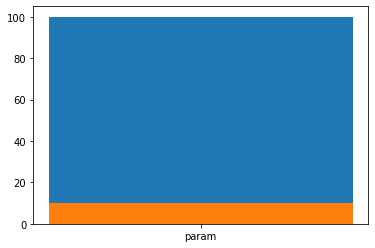

In [31]:
x = ["param"]
fig, ax = plt.subplots()
ax.bar(x,[100])
ax.bar(x, [10])
plt.show()

In [47]:
x = torch.randn((13,7,11))
x.sum((-2,-1))

tensor([ -4.9928,   4.9012,   9.7622, -16.6574, -11.7252,   1.4748,   0.6267,
         -9.7920,  -4.4635,  -5.2804,   8.4822,  16.3198,   8.9842])

In [48]:
torch.einsum("abc->a",x)

tensor([ -4.9928,   4.9012,   9.7622, -16.6574, -11.7252,   1.4748,   0.6267,
         -9.7920,  -4.4635,  -5.2804,   8.4822,  16.3198,   8.9842])

In [75]:
x.mean(-1)

tensor([[-0.3211, -0.0321,  0.3448, -0.3467, -0.2131, -0.2474,  0.3617],
        [ 0.0813,  0.1287, -0.2923,  0.1036,  0.4778,  0.0651, -0.1186],
        [-0.1493, -0.0045,  0.3181,  0.3579,  0.0219, -0.2029,  0.5464],
        [-0.4007, -0.1336, -0.6260, -0.1423, -0.1100,  0.0151, -0.1168],
        [-0.2416,  0.3958, -0.3093, -0.1704,  0.4229, -0.7369, -0.4264],
        [-0.3542,  0.2005,  0.7623, -0.4718,  0.3173, -0.1951, -0.1250],
        [-0.2685,  0.1774, -0.0405, -0.3721,  0.1492,  0.3126,  0.0989],
        [-0.1015, -0.5837,  0.6358, -0.0481, -0.3747, -0.1684, -0.2497],
        [ 0.4587, -0.2433,  0.0860, -0.1310,  0.1735, -0.3761, -0.3736],
        [-0.1139, -0.0109, -0.2122, -0.3275, -0.2340,  0.3204,  0.0979],
        [ 0.1052,  0.4227, -0.0907, -0.2231,  0.1939, -0.1365,  0.4996],
        [ 0.1439,  0.2337,  0.5574,  0.1092,  0.2914,  0.4421, -0.2940],
        [ 0.1203, -0.3396,  0.0831,  0.3437,  0.5117, -0.0987,  0.1962]])

In [78]:
x.sum(-1)/x.shape[-1] - x.mean(-1)

tensor([[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]])

In [80]:
x.mean((-2,-1))

tensor([-0.0648,  0.0637,  0.1268, -0.2163, -0.1523,  0.0192,  0.0081, -0.1272,
        -0.0580, -0.0686,  0.1102,  0.2119,  0.1167])

In [85]:
x.shape[-2, -1]

TypeError: tuple indices must be integers or slices, not tuple

In [52]:
torch.einsum("abc->ab",x)

tensor([[-3.5319, -0.3529,  3.7930, -3.8141, -2.3437, -2.7218,  3.9787],
        [ 0.8943,  1.4159, -3.2153,  1.1397,  5.2557,  0.7157, -1.3050],
        [-1.6423, -0.0500,  3.4989,  3.9365,  0.2408, -2.2323,  6.0106],
        [-4.4078, -1.4696, -6.8858, -1.5658, -1.2104,  0.1666, -1.2847],
        [-2.6579,  4.3536, -3.4018, -1.8749,  4.6523, -8.1059, -4.6906],
        [-3.8964,  2.2059,  8.3858, -5.1897,  3.4905, -2.1459, -1.3754],
        [-2.9534,  1.9513, -0.4451, -4.0936,  1.6414,  3.4385,  1.0876],
        [-1.1165, -6.4204,  6.9940, -0.5287, -4.1218, -1.8522, -2.7464],
        [ 5.0456, -2.6760,  0.9459, -1.4408,  1.9083, -4.1369, -4.1096],
        [-1.2524, -0.1198, -2.3344, -3.6022, -2.5737,  3.5248,  1.0774],
        [ 1.1575,  4.6498, -0.9976, -2.4541,  2.1324, -1.5014,  5.4956],
        [ 1.5825,  2.5709,  6.1310,  1.2015,  3.2053,  4.8629, -3.2344],
        [ 1.3238, -3.7360,  0.9137,  3.7806,  5.6291, -1.0854,  2.1584]])

In [86]:
from typing import List
def sum(inp: torch.Tensor, dims: List[int]):
    # convert dims to positive indices
    dims_positive = []
    for d in dims:
        if d >= 0:
            dims_positive.append(d)
        else:
            dims_positive.append(len(inp.shape)+d)
    
    lhs = ''.join(chr(ord('a')+i) for i in range(len(inp.shape)))
    rhs = [] # rhs
    for i in range(len(inp.shape)):
        if i not in dims_positive:
            rhs.append(chr(ord('a')+i))
    rhs = ''.join(rhs)
    if rhs=="":
        rhs="..."
    print(f"{lhs}->{rhs}")
    return torch.einsum(f"{lhs}->{rhs}", inp)
def mean(inp: torch.Tensor, dims: List[int]):
    # todo use prod lol
    denom = 1
    for d in dims:
        denom *=inp.shape[d]
    return sum(inp, dims) / denom 

In [79]:
~torch.any( ~(x.sum((-1,-2)) == sum(x, (-1, -2))))

abc->a


tensor(True)

In [87]:
x.mean(-1) == mean(x, [-1])

abc->ab


tensor([[True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True]])

In [96]:
sum(x, [-1])/x.shape[-1]

abc->ab


tensor([[-0.3211, -0.0321,  0.3448, -0.3467, -0.2131, -0.2474,  0.3617],
        [ 0.0813,  0.1287, -0.2923,  0.1036,  0.4778,  0.0651, -0.1186],
        [-0.1493, -0.0045,  0.3181,  0.3579,  0.0219, -0.2029,  0.5464],
        [-0.4007, -0.1336, -0.6260, -0.1423, -0.1100,  0.0151, -0.1168],
        [-0.2416,  0.3958, -0.3093, -0.1704,  0.4229, -0.7369, -0.4264],
        [-0.3542,  0.2005,  0.7623, -0.4718,  0.3173, -0.1951, -0.1250],
        [-0.2685,  0.1774, -0.0405, -0.3721,  0.1492,  0.3126,  0.0989],
        [-0.1015, -0.5837,  0.6358, -0.0481, -0.3747, -0.1684, -0.2497],
        [ 0.4587, -0.2433,  0.0860, -0.1310,  0.1735, -0.3761, -0.3736],
        [-0.1139, -0.0109, -0.2122, -0.3275, -0.2340,  0.3204,  0.0979],
        [ 0.1052,  0.4227, -0.0907, -0.2231,  0.1939, -0.1365,  0.4996],
        [ 0.1439,  0.2337,  0.5574,  0.1092,  0.2914,  0.4421, -0.2940],
        [ 0.1203, -0.3396,  0.0831,  0.3437,  0.5117, -0.0987,  0.1962]])

In [90]:
torch.mean(x, -1)

tensor([[-0.3211, -0.0321,  0.3448, -0.3467, -0.2131, -0.2474,  0.3617],
        [ 0.0813,  0.1287, -0.2923,  0.1036,  0.4778,  0.0651, -0.1186],
        [-0.1493, -0.0045,  0.3181,  0.3579,  0.0219, -0.2029,  0.5464],
        [-0.4007, -0.1336, -0.6260, -0.1423, -0.1100,  0.0151, -0.1168],
        [-0.2416,  0.3958, -0.3093, -0.1704,  0.4229, -0.7369, -0.4264],
        [-0.3542,  0.2005,  0.7623, -0.4718,  0.3173, -0.1951, -0.1250],
        [-0.2685,  0.1774, -0.0405, -0.3721,  0.1492,  0.3126,  0.0989],
        [-0.1015, -0.5837,  0.6358, -0.0481, -0.3747, -0.1684, -0.2497],
        [ 0.4587, -0.2433,  0.0860, -0.1310,  0.1735, -0.3761, -0.3736],
        [-0.1139, -0.0109, -0.2122, -0.3275, -0.2340,  0.3204,  0.0979],
        [ 0.1052,  0.4227, -0.0907, -0.2231,  0.1939, -0.1365,  0.4996],
        [ 0.1439,  0.2337,  0.5574,  0.1092,  0.2914,  0.4421, -0.2940],
        [ 0.1203, -0.3396,  0.0831,  0.3437,  0.5117, -0.0987,  0.1962]])

In [106]:
torch.var(x, (-2,-1))

tensor([1.1006, 0.9720, 1.0649, 1.0924, 0.8405, 1.2960, 1.0906, 0.9332, 1.1878,
        0.8984, 1.2499, 0.9131, 0.8298])

In [108]:
x.mean((-2,-1)).shape#.unsqueeze((-2,-1)))#.square().sum(-1)/(x.shape[-1]-1)

torch.Size([13])

In [101]:
x.shape

torch.Size([13, 7, 11])

In [104]:
torch.var(x, -1).shape

torch.Size([13, 7])

In [115]:
torch.einsum("abc->...",x)

tensor(-2.3601)